# **1. Data Loading, Validation, and Merging**

In [66]:
!pip install scikit-surprise

In [67]:
!pip install numpy==1.24.3

In [68]:
!pip install scikit-surprise

In [69]:
import pandas as pd
from scipy.sparse import csr_matrix
# from sklearn.neighbors import NearestNeighbors
import numpy as np
from surprise import KNNWithMeans


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import pandas as pd
import requests
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [71]:
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Health_and_Personal_Care.jsonl.gz'
url2 = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/meta_categories/meta_Health_and_Personal_Care.jsonl.gz'

# Make the request
response = requests.get(url, allow_redirects=True)
response2 = requests.get(url2, allow_redirects=True)
# Check content type
print('Content-Type:', response.headers.get('Content-Type'))
print('Content-Type:', response2.headers.get('Content-Type'))
# Check the beginning of the content to ensure it's not HTML
print(response.content[:100])
print(response2.content[:100])

# If the content type and content check out, save the file
if response.headers.get('Content-Type') in ['application/gzip', 'application/x-gzip']:
    with open('Health_and_Personal_Care.jsonl.gz', 'wb') as f:
        f.write(response.content)
    print("File downloaded and saved!")
else:
    print("The downloaded content is not a gzip file.")

#for file 2
if response2.headers.get('Content-Type') in ['application/gzip', 'application/x-gzip']:
    with open('Health_and_Personal_Care_metadata.jsonl.gz', 'wb') as f:
        f.write(response2.content)
    print("File downloaded and saved!")
else:
    print("The downloaded content is not a gzip file.")

Content-Type: text/html; charset=iso-8859-1
Content-Type: text/html; charset=iso-8859-1
b'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>404 Not Found</title>\n</head>'
b'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>404 Not Found</title>\n</head>'
The downloaded content is not a gzip file.
The downloaded content is not a gzip file.


In [72]:
file_path = 'Health_and_Personal_Care.jsonl.gz'

# Read the .jsonl.gz file directly into a DataFrame
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    data = pd.read_json(file, lines=True)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             494121 non-null  int64         
 1   title              494121 non-null  object        
 2   text               494121 non-null  object        
 3   images             494121 non-null  object        
 4   asin               494121 non-null  object        
 5   parent_asin        494121 non-null  object        
 6   user_id            494121 non-null  object        
 7   timestamp          494121 non-null  datetime64[ns]
 8   helpful_vote       494121 non-null  int64         
 9   verified_purchase  494121 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 34.4+ MB
None


In [73]:
# Validate data, ensure 'rating' is between 1 and 5 by confirming the Non-Null Count is same as the old df
data = data[(data['rating'] >= 1) & (data['rating'] <= 5)]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             494121 non-null  int64         
 1   title              494121 non-null  object        
 2   text               494121 non-null  object        
 3   images             494121 non-null  object        
 4   asin               494121 non-null  object        
 5   parent_asin        494121 non-null  object        
 6   user_id            494121 non-null  object        
 7   timestamp          494121 non-null  datetime64[ns]
 8   helpful_vote       494121 non-null  int64         
 9   verified_purchase  494121 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 34.4+ MB
None


In [74]:
file_path2 = '/content/meta_Health_and_Personal_Care.jsonl.gz'


# Read the .jsonl.gz file directly into a DataFrame
with gzip.open(file_path2, 'rt', encoding='utf-8') as file:
    df_meta = pd.read_json(file, lines=True)

print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60293 entries, 0 to 60292
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    60293 non-null  object 
 1   title            60293 non-null  object 
 2   average_rating   60293 non-null  float64
 3   rating_number    60293 non-null  int64  
 4   features         60293 non-null  object 
 5   description      60293 non-null  object 
 6   price            10536 non-null  float64
 7   images           60293 non-null  object 
 8   videos           60293 non-null  object 
 9   store            57947 non-null  object 
 10  categories       60293 non-null  object 
 11  details          60293 non-null  object 
 12  parent_asin      60293 non-null  object 
 13  bought_together  0 non-null      float64
dtypes: float64(3), int64(1), object(10)
memory usage: 6.4+ MB
None


In [75]:
#Validation: Ensure no uplicate parent_asin is in meta data
unique_row_df2 = df_meta.drop_duplicates(subset=['parent_asin'])
print(unique_row_df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60293 entries, 0 to 60292
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    60293 non-null  object 
 1   title            60293 non-null  object 
 2   average_rating   60293 non-null  float64
 3   rating_number    60293 non-null  int64  
 4   features         60293 non-null  object 
 5   description      60293 non-null  object 
 6   price            10536 non-null  float64
 7   images           60293 non-null  object 
 8   videos           60293 non-null  object 
 9   store            57947 non-null  object 
 10  categories       60293 non-null  object 
 11  details          60293 non-null  object 
 12  parent_asin      60293 non-null  object 
 13  bought_together  0 non-null      float64
dtypes: float64(3), int64(1), object(10)
memory usage: 6.4+ MB
None


In [76]:
merged_df = pd.merge(data, unique_row_df2, on='parent_asin', how='inner')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494121 entries, 0 to 494120
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             494121 non-null  int64         
 1   title_x            494121 non-null  object        
 2   text               494121 non-null  object        
 3   images_x           494121 non-null  object        
 4   asin               494121 non-null  object        
 5   parent_asin        494121 non-null  object        
 6   user_id            494121 non-null  object        
 7   timestamp          494121 non-null  datetime64[ns]
 8   helpful_vote       494121 non-null  int64         
 9   verified_purchase  494121 non-null  bool          
 10  main_category      494121 non-null  object        
 11  title_y            494121 non-null  object        
 12  average_rating     494121 non-null  float64       
 13  rating_number      494121 non-null  int64   

# **2. Data Exploration**

In [77]:
#Number of unique users
print("Count of unique user_ids: ",merged_df['user_id'].nunique())

Count of unique user_ids:  461656


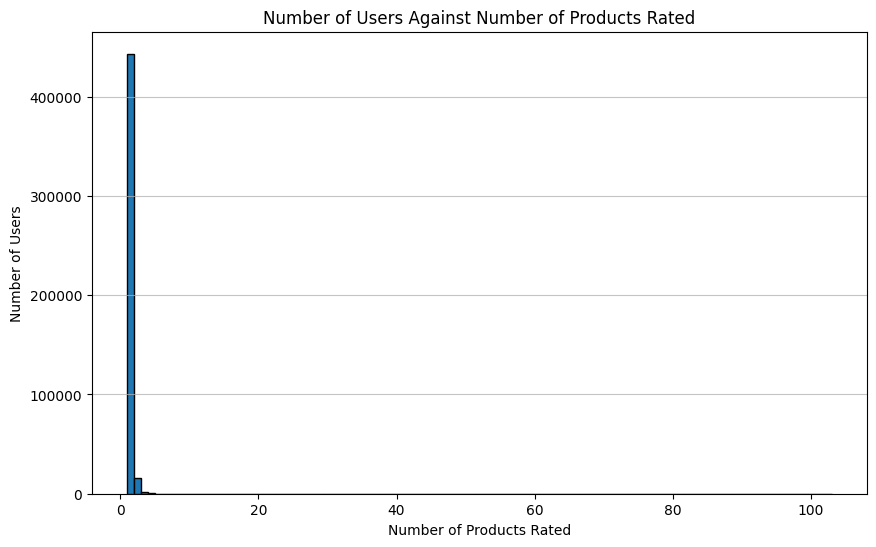

In [78]:
user_product_counts = merged_df.groupby('user_id')['parent_asin'].nunique()

# Plot the number of users against the number of products they rated
plt.figure(figsize=(10, 6))
plt.hist(user_product_counts, bins=range(1, user_product_counts.max() + 2), edgecolor='black')
plt.xlabel('Number of Products Rated')
plt.ylabel('Number of Users')
plt.title('Number of Users Against Number of Products Rated')
plt.grid(axis='y', alpha=0.75)
plt.show()

From the plot above, you can see that most users have rated minimal number of items.

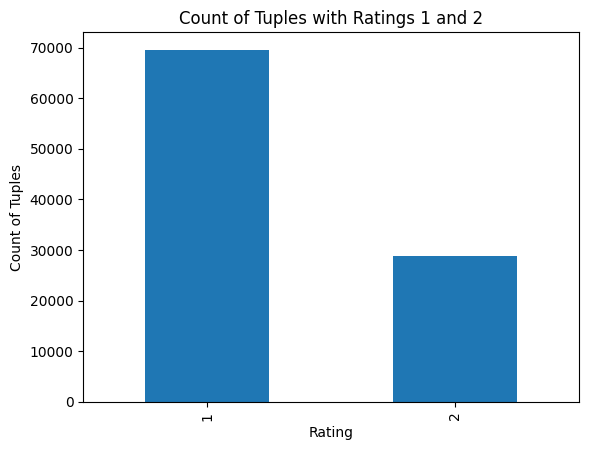

In [79]:
filtered_df = merged_df[merged_df['rating'].isin([1, 2])]

# Count the occurrences of each rating
rating_counts = filtered_df['rating'].value_counts()

# Plot the counts
rating_counts.plot(kind='bar', xlabel='Rating', ylabel='Count of Tuples', title='Count of Tuples with Ratings 1 and 2')
plt.show()

In [80]:
count= len(filtered_df)
print("Number of tuples with rating of 1 or 2: ", count)

Number of tuples with rating of 1 or 2:  98459


Count of tuples with ratings of 1 or 2 is 98,459.

In [81]:
#Drop tuples with a rating of 1 or 2
indices_to_drop = filtered_df.index
reduced_df = merged_df.drop(indices_to_drop)

num_rows, num_columns = reduced_df.shape
print("Reduced dataset size after dropping low ratings:", num_rows)

Reduced dataset size after dropping low ratings: 395662


Tuples with low ratings are dropped since we're only interested in high ratings.

Dataset was reduced by 20%, from 494,121 to 395,662.

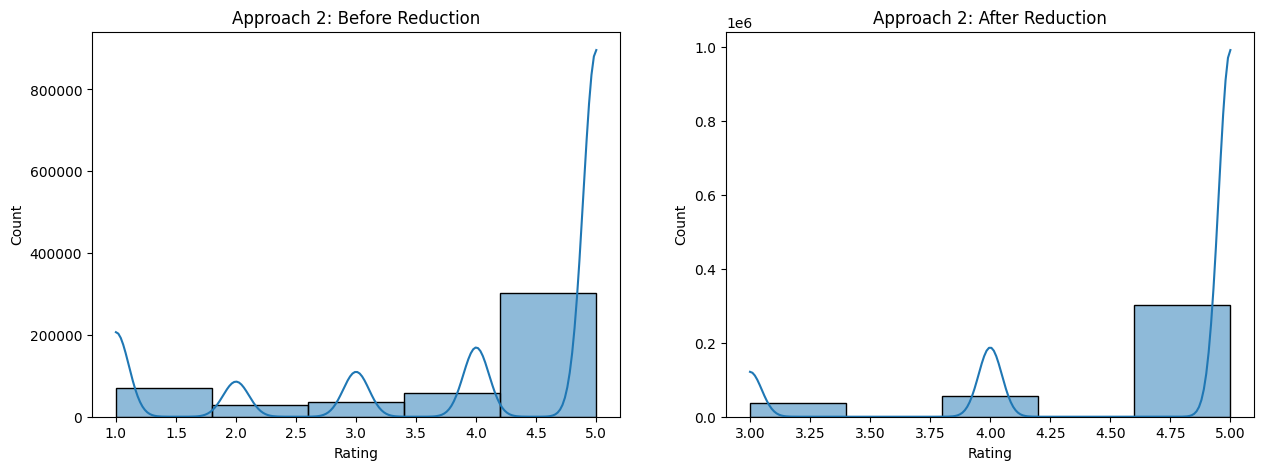

In [82]:
# Visualize the Rating distribution before and after dropping values with ratings equal to 4 or less
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before reduction
axes[0].set_title('Approach 2: Before Reduction')
sns.histplot(merged_df['rating'], bins=5, kde=True, ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')

# After reduction
axes[1].set_title('Approach 2: After Reduction')
sns.histplot(reduced_df['rating'], bins=5, kde=True, ax=axes[1])
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')

plt.show()




In [83]:
#Number of unique users
print("Count of unique user_ids after data reduction: ",reduced_df['user_id'].nunique())

Count of unique user_ids after data reduction:  369758


Number of unique user_ids after data reduction dropped also dropped by 20%, from 461,656 to 369,758

In [84]:
user_rating_counts = reduced_df.groupby('user_id').size() #Gives me the number of ratings by each user

users_grouped_by_rating_count = user_rating_counts.groupby(user_rating_counts).size() #Groups users who rated once, twice, ...

print("Ratings count, users_ids count: \n \n",users_grouped_by_rating_count)

Ratings count, users_ids count: 
 
 1      351921
2       14994
3        1662
4         508
5         189
6         130
7          76
8          52
9          40
10         26
11         18
12         24
13          8
14         16
15         11
16         11
17          5
18          8
19          2
20          2
21          5
22          6
23          2
24          5
25          2
26          1
27          2
29          1
30          3
31          6
32          2
33          2
35          1
36          1
37          1
38          1
40          1
42          1
44          2
45          1
47          1
49          1
55          1
57          1
69          1
71          1
81          1
105         1
117         1
dtype: int64


In [85]:
users_rated_L4 = users_grouped_by_rating_count[users_grouped_by_rating_count.index < 4]

total_sum = 0

# Loop through the index and value pairs
for index, value in users_rated_L4.items():
    total_sum += index * value
print("Number of tuples with users who rated less than 4 times: ", total_sum)

Number of tuples with users who rated less than 4 times:  386895


Number of tuples with users who rated less than 4 times resembels 97.7% of the reduced data

In [86]:
# Filter users who rated 4 or more
users_count_4T_or_more = users_grouped_by_rating_count[users_grouped_by_rating_count.index >= 4]

total_sum = 0

# Loop through the index and value pairs
for index, value in users_count_4T_or_more.items():
    total_sum += index * value

print("Sum of tuples with users who rated four or more or more: ", total_sum)

Sum of tuples with users who rated four or more or more:  8767


Number of tuples with users who rated 4 times or more resembles 2.2% of the reduced data

In [87]:
#Checkpoint
users_rated_4T_or_more = user_rating_counts[user_rating_counts >= 4]

# Get the user IDs of users who rated 4 times or more
user_ids_rated_4T_or_more = users_rated_4T_or_more.index.tolist()

print(user_ids_rated_4T_or_more)

['AE23ZBUF2YVBQPH2NN6F5XSA3QYQ', 'AE2ICCS6RNIW5ESU43P3PRTM6KLA', 'AE2IGWDKOWONDB3FQFX3STYGWCNQ', 'AE2M6S7S7AAQTPH7YU77ROMEKRSA', 'AE2MAEFMERCE3BZJQEU5YH4TKJ7Q', 'AE2O2C43KTYO4LXXGZWJZLE67GBQ', 'AE2P7CYKD2QEVJ543B65G32BY2GQ', 'AE2Q2ALSTU2ULCAD3566ZXM4NNOQ', 'AE2UEKR44HZMOUKZVZI5AFRLJWDQ', 'AE2WMFLNQAV4U5O5XL7AU7LYSL3Q', 'AE2YCIHHZH57ABZB7EWDTCF3WPKA', 'AE3335XF4PMHSXKTW5B7N7EALG3Q', 'AE35PCM2KBCWJ6GVCK4WYQGR5SHQ', 'AE3CYTYHKHSUBERO47JU3JQKS44A', 'AE3IGJOPJP6LFXEJTIXFJVSJLILA', 'AE3IWCZ2MUUKU2LQIVTOWYVVHHSQ', 'AE3KLVXGZPANXE5XLXYKHTVAZ3FQ', 'AE3OM5AZMQNYX25VDMO652FP7IOQ', 'AE3PLZHW6NXWBMZ76TDVFQG2MJFA', 'AE3TSST7D3QYFO2MUZ3QFNMYAEHQ', 'AE4FQVS6CJVC3QDQ7C2CPAJAZM4A', 'AE4JPPM4YPZ4EONHBXME6VWPVS2Q', 'AE4JZHP4SICSSJPIAAM7K7PFMFIA', 'AE4KAQGQGMRTPDP22RSMQP4QGPWQ', 'AE4MX6BOTJEFI5NKIBWCGDCNHCOQ', 'AE4QAO4P4PPKJAVJRAYV4EEAONBA', 'AE4WM6BGRN4EPDDG5G24X2NJISXQ', 'AE4YB4AE5WZMIZHVUVRP3TXCK5QA', 'AE4ZEVKADHYWL6PJZJ2AC75JJY4A', 'AE5CXHJTPWY4NF2IIH2N5HQBYBJA', 'AE5EMAHTS63NPZ5SRRNV5WCSJHGA', 'AE5ESL

In [88]:
# Select tuples with user IDs from user_ids_rated_4T_or_more
reduced_df2 = reduced_df[reduced_df['user_id'].isin(user_ids_rated_4T_or_more)]

print("Further reduced dataset size after dropping users who rated less than 4 times:", reduced_df2.shape[0])

Further reduced dataset size after dropping users who rated less than 4 times: 8767


Dataset was further reduced by 97.7% by removing tuples with users who rated less than 4 times from 369,758 to 8767

In [89]:
#Number of unique users
print("Count of unique user_ids after data reduction: ",reduced_df2['user_id'].nunique())

Count of unique user_ids after data reduction:  1181


After the second round of data reduction, the number of unique user_ids dropped by 99.68% when compared to the number of unique users from the first round of data reduction. And it dropped by 99.74% compared to orginial number of unique users.

Total unique user_ids: 461,656

Unique user_ids in reduced_df: 369,758

Unique user_ids in reduced_df2: 1,181

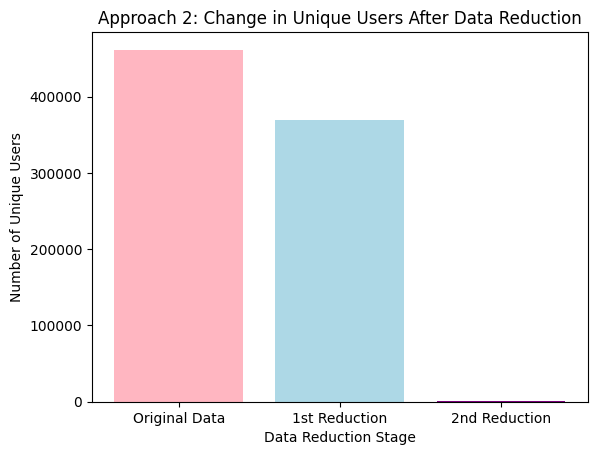

In [90]:
# plot the change in the number of unique users after two data reductions
num_users_original = merged_df['user_id'].nunique()
num_users_reduced_1 = reduced_df['user_id'].nunique()
num_users_reduced_2 = reduced_df2['user_id'].nunique()

x = ['Original Data', '1st Reduction', '2nd Reduction']
y = [num_users_original, num_users_reduced_1, num_users_reduced_2]

plt.bar(x, y, color=['lightpink', 'lightblue', 'purple'])
plt.xlabel('Data Reduction Stage')
plt.ylabel('Number of Unique Users')
plt.title('Approach 2: Change in Unique Users After Data Reduction')
plt.show()


In [91]:
#Show how many parent_asin rated 1 and 2

ratings_count = reduced_df2.groupby('parent_asin').size()

filtered_ratings_count = ratings_count[(ratings_count == 1) | (ratings_count == 2)]

count_one_or_two_ratings = len(filtered_ratings_count)

print("Number of parent_asin values with only one or two ratings:", count_one_or_two_ratings)


Number of parent_asin values with only one or two ratings: 2165


25% of reduced_df2 consists of parent_asin rated once or twice. This can lead to challenges in predicting some of the ratings

# **3. Data Initialization**

In [92]:
# Filter out the data with ratings greater than 2
reduced_data = merged_df[merged_df['average_rating'] > 2]
reduced_data


,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,rating_number,features,description,price,images_y,videos,store,categories,details,bought_together
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True,...,470,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Life Nutrition,[],"{'Brand': 'Life Nutrition', 'Unit Count': '60 ...",NaN
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True,...,181,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Great for bathroom cleaning!', 'ur...",Evolve,[],"{'Brand': 'Evolve', 'Scent': 'Fresh,Lemon', 'P...",NaN
2,5,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2019-07-24 11:13:58.905,0,True,...,78,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Very soft and comfortable, easy to...",Dr.Foot,[],"{'Is Discontinued By Manufacturer': 'No', 'Pro...",NaN
3,4,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,2022-09-04 02:29:02.725,7,True,...,8312,[Fizz your feet: Active bubble massage soothes...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'My opinion on this foot spa. ', 'u...",Homedics,[],"{'Use for': 'Feet', 'Power Source': 'Corded El...",NaN
4,1,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:53:07.262,0,True,...,94,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Nature's Nutrition,[],"{'Brand': 'Nature's Nutrition', 'Unit Count': ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494116,5,Best brush!,"Material is good. Worthy to buy.Firstly, the c...",[],B07KXT7Y48,B07KXT7Y48,AEQG5UEVYBNLWPXB3E2EODQ3EGSQ,2019-04-12 04:21:04.257,6,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494117,5,It makes my skin softer.,This brush is a good tool for cleaning and mas...,[],B07KXT7Y48,B07KXT7Y48,AGTVLNJAFZTKURBCHLUIH6VEOQCQ,2020-07-17 05:01:39.190,0,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494118,5,This brush is perfect !,"Honestly, the brush totally is 15inch. Maybe y...",[{'small_image_url': 'https://images-na.ssl-im...,B07KXT7Y48,B07KXT7Y48,AGMA5UN3JPLQLQZ2PFYHJYSC4PNA,2019-03-07 22:33:36.968,173,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494119,5,Easy to use,"Easy to hold, soft and flexible.",[],B07KXT7Y48,B07KXT7Y48,AE2Q3FXHIVGSSDGTNI4YLXDXMCIA,2019-09-26 12:22:51.244,0,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN


In [93]:
reduced_data.info()
reduced_data


<class 'pandas.core.frame.DataFrame'>
Index: 490799 entries, 0 to 494120
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             490799 non-null  int64         
 1   title_x            490799 non-null  object        
 2   text               490799 non-null  object        
 3   images_x           490799 non-null  object        
 4   asin               490799 non-null  object        
 5   parent_asin        490799 non-null  object        
 6   user_id            490799 non-null  object        
 7   timestamp          490799 non-null  datetime64[ns]
 8   helpful_vote       490799 non-null  int64         
 9   verified_purchase  490799 non-null  bool          
 10  main_category      490799 non-null  object        
 11  title_y            490799 non-null  object        
 12  average_rating     490799 non-null  float64       
 13  rating_number      490799 non-null  int64        

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,rating_number,features,description,price,images_y,videos,store,categories,details,bought_together
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True,...,470,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Life Nutrition,[],"{'Brand': 'Life Nutrition', 'Unit Count': '60 ...",NaN
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True,...,181,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Great for bathroom cleaning!', 'ur...",Evolve,[],"{'Brand': 'Evolve', 'Scent': 'Fresh,Lemon', 'P...",NaN
2,5,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2019-07-24 11:13:58.905,0,True,...,78,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Very soft and comfortable, easy to...",Dr.Foot,[],"{'Is Discontinued By Manufacturer': 'No', 'Pro...",NaN
3,4,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,2022-09-04 02:29:02.725,7,True,...,8312,[Fizz your feet: Active bubble massage soothes...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'My opinion on this foot spa. ', 'u...",Homedics,[],"{'Use for': 'Feet', 'Power Source': 'Corded El...",NaN
4,1,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:53:07.262,0,True,...,94,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Nature's Nutrition,[],"{'Brand': 'Nature's Nutrition', 'Unit Count': ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494116,5,Best brush!,"Material is good. Worthy to buy.Firstly, the c...",[],B07KXT7Y48,B07KXT7Y48,AEQG5UEVYBNLWPXB3E2EODQ3EGSQ,2019-04-12 04:21:04.257,6,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494117,5,It makes my skin softer.,This brush is a good tool for cleaning and mas...,[],B07KXT7Y48,B07KXT7Y48,AGTVLNJAFZTKURBCHLUIH6VEOQCQ,2020-07-17 05:01:39.190,0,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494118,5,This brush is perfect !,"Honestly, the brush totally is 15inch. Maybe y...",[{'small_image_url': 'https://images-na.ssl-im...,B07KXT7Y48,B07KXT7Y48,AGMA5UN3JPLQLQZ2PFYHJYSC4PNA,2019-03-07 22:33:36.968,173,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN
494119,5,Easy to use,"Easy to hold, soft and flexible.",[],B07KXT7Y48,B07KXT7Y48,AE2Q3FXHIVGSSDGTNI4YLXDXMCIA,2019-09-26 12:22:51.244,0,True,...,377,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Bath Scrubber Body Brush Shower Sc...,CJSJ,[],"{'Brand': 'CJSJ', 'Color': 'Blue', 'Power Sour...",NaN


In [94]:
#group the users
product_count_by_user = reduced_data.groupby('user_id').size()
product_count_by_user



,0
user_id,
AE222BXSMOAK65FICCF3SAG2FTIA,1
AE222CDPBUOEJLIFR5X6KMP7YDFA,1
AE222HRNGARBTPMBFOETLSAGJMHA,1
AE222LBLDIVPM4XEAAVWPUAY54BA,1
AE222OUMMJSNQDOUJ5CXJ5IZ2EGQ,1
...,...
AHZZZ6OLGGSAUFFBL2W5FRPVVPPQ,1
AHZZZCVRM3TP6MMKLO7EMMZWTMEQ,1
AHZZZHGU343QNC3EIRNNPNX5BYBQ,1


In [95]:
#sort them from biggest to smallest
product_count_by_user_sorted = product_count_by_user.sort_values(ascending=True)


In [96]:
# filter out any users that have rated less than 4 items
product_count_by_user_sorted_filtered = product_count_by_user_sorted[product_count_by_user_sorted > 4 ]



In [97]:
product_count_by_user_sorted_filtered


,0
user_id,
AESBTBBALFHCIHADPPIDW7EMXQNA,5
AEGKJTQWHGBIOTO34OB3GKIGCN7A,5
AGA3V7ICXKHCESK7AQJKH2ZIP62A,5
AGCFG23Q7EF545HGZ7V2KAW4RO2Q,5
AFB3QHU3MOWSWQ7ISC5I7JISKQVQ,5
...,...
AHPGHDFIU3BUB3RQBP56RQQA7W4Q,73
AG73BVBKUOH22USSFJA5ZWL7AKXA,81
AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,84


In [98]:
product_count_by_user_sorted_filtered_df = product_count_by_user_sorted_filtered.reset_index()
product_count_by_user_sorted_filtered_df.columns = ['user_id', 'count']

product_count_by_user_sorted_filtered_df


,user_id,count
0,AESBTBBALFHCIHADPPIDW7EMXQNA,5
1,AEGKJTQWHGBIOTO34OB3GKIGCN7A,5
2,AGA3V7ICXKHCESK7AQJKH2ZIP62A,5
3,AGCFG23Q7EF545HGZ7V2KAW4RO2Q,5
4,AFB3QHU3MOWSWQ7ISC5I7JISKQVQ,5
...,...,...
760,AHPGHDFIU3BUB3RQBP56RQQA7W4Q,73
761,AG73BVBKUOH22USSFJA5ZWL7AKXA,81
762,AFXF3EGQTQDXMRLDWFU7UBFQZB7Q,84
763,AEYVPPWR4CIKWX4BGYKCBCDL2CZQ,106


The user IDs and the ratings that have been removed to form the final matrix reduced_data


In [99]:
reduced_data = reduced_data[reduced_data['user_id'].isin(product_count_by_user_sorted_filtered_df['user_id'])]
reduced_data


,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,rating_number,features,description,price,images_y,videos,store,categories,details,bought_together
5,5,Every home should have these,"I have never been big on vitamins, with the ex...",[],B09GBMG83Z,B09GBMG83Z,AFSKPY37N3C43SOI5IEXEK5JSIYA,2022-02-21 00:14:54.796,1,False,...,653,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Video Review Best Vitamin C 500 MG...,Carlyle,[],"{'Brand': 'Carlyle', 'Primary Supplement Type'...",NaN
6,4,Versatile shaver,"To be honest, my husband did not use this for ...",[],B09FKT5PQ9,B09FKT5PQ9,AFSKPY37N3C43SOI5IEXEK5JSIYA,2022-02-07 20:38:46.005,0,False,...,215,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Youtelit,[],"{'Brand': 'Youtelit', 'Recommended Uses For Pr...",NaN
7,4,Makes a nice compact noise machine to take wit...,This is a nice basic sound machine. I have use...,[],B08THJD1MH,B08THJD1MH,AFSKPY37N3C43SOI5IEXEK5JSIYA,2021-04-08 18:45:34.645,0,False,...,16,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Battery operated sound machine w/t...,Afloia,[],"{'Brand': 'Afloia', 'Power Source': 'Corded El...",NaN
8,5,Great drawstring holiday bags!,This are super colorful great gift giving holi...,[],B08FCQML37,B08FCQML37,AFSKPY37N3C43SOI5IEXEK5JSIYA,2020-12-15 21:15:39.529,0,False,...,14,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],SOSMAR,[],"{'Brand': 'SOSMAR', 'Material': 'Plastic', 'Oc...",NaN
9,3,Not as good as the name brand whitening strips...,I guess the only product I have in my history ...,[],B08GYM3HVP,B08GYM3HVP,AFSKPY37N3C43SOI5IEXEK5JSIYA,2020-10-14 21:25:18.369,0,False,...,2,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Setber,[],"{'Brand': 'Setber', 'Item Form': 'Strip', 'Uni...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490258,1,Do not buy,Do not buy. I just could not return the item b...,[],B0141GTXGA,B0141GTXGA,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,2019-12-12 02:01:17.269,1,True,...,1445,[],[Oster Blade],28.7,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Tools I use on a zero fade ', 'url...",Oster,[],{'Recommended Uses For Product': 'Professional...,NaN
490259,1,Do not buy,Do not buy. I just could not return the item b...,[],B0141GTXGA,B0141GTXGA,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,2019-12-12 02:01:17.269,1,True,...,1445,[],[Oster Blade],28.7,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Tools I use on a zero fade ', 'url...",Oster,[],{'Recommended Uses For Product': 'Professional...,NaN
490261,1,Do not buy,Do not buy. I just could not return the item b...,[],B0141GTXGA,B0141GTXGA,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,2019-12-12 02:01:17.269,1,True,...,1445,[],[Oster Blade],28.7,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Tools I use on a zero fade ', 'url...",Oster,[],{'Recommended Uses For Product': 'Professional...,NaN
490262,1,Do not buy,Do not buy. I just could not return the item b...,[],B0141GTXGA,B0141GTXGA,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,2019-12-12 02:01:17.269,1,True,...,1445,[],[Oster Blade],28.7,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Tools I use on a zero fade ', 'url...",Oster,[],{'Recommended Uses For Product': 'Professional...,NaN


In [100]:
reduced_data2 = reduced_data[['average_rating', 'user_id', 'parent_asin']]

reduced_data2


,average_rating,user_id,parent_asin
5,4.5,AFSKPY37N3C43SOI5IEXEK5JSIYA,B09GBMG83Z
6,3.6,AFSKPY37N3C43SOI5IEXEK5JSIYA,B09FKT5PQ9
7,2.8,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08THJD1MH
8,4.1,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08FCQML37
9,3.7,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08GYM3HVP
...,...,...,...
490258,4.8,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA
490259,4.8,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA
490261,4.8,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA
490262,4.8,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA


In [101]:
test_matrix = reduced_data2.pivot_table(index='parent_asin', columns='user_id', values='average_rating')

# Fill missing values with zeros
test_matrix = test_matrix.fillna(0)

test_matrix



user_id,AE23ZBUF2YVBQPH2NN6F5XSA3QYQ,AE2IGWDKOWONDB3FQFX3STYGWCNQ,AE2M6S7S7AAQTPH7YU77ROMEKRSA,AE2O2C43KTYO4LXXGZWJZLE67GBQ,AE2WMFLNQAV4U5O5XL7AU7LYSL3Q,AE2YCIHHZH57ABZB7EWDTCF3WPKA,AE3335XF4PMHSXKTW5B7N7EALG3Q,AE35PCM2KBCWJ6GVCK4WYQGR5SHQ,AE3CYTYHKHSUBERO47JU3JQKS44A,AE3IGJOPJP6LFXEJTIXFJVSJLILA,...,AHYUFOFTGNEV4TGMQLASS6EA7QAQ,AHZ4TADPCXAAIKTFERGG5YB4BNQQ,AHZFD4ST553YYIMWTM43TAGLMVHQ,AHZGQXTGR3WB6CQR3PP2TB2YPTUA,AHZGQXTGR3WB6CQR3PP2TB2YPTUA_1,AHZGQXTGR3WB6CQR3PP2TB2YPTUA_2,AHZHU6Z2YL2Z6UBEZ35KMCW2P37Q,AHZJXRSEQSJ5TKYWWINKEORIBYSA,AHZNKRM4GX4HPSWFTIVDFQHO4EGA,AHZTLIV6ZHPGSLNSXMODLEKP62FQ
parent_asin,,,,,,,,,,,,,,,,,,,,,
B00009QJW6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0000A605R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00015QDHI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00016QZ0C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0001ZWPI4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0C5MV8HHP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0C6H6RRVB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0C71W41C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0


In [102]:
rating_data = reduced_data2[['user_id', 'parent_asin', 'average_rating']]
rating_data = pd.DataFrame(rating_data)
rating_data

,user_id,parent_asin,average_rating
5,AFSKPY37N3C43SOI5IEXEK5JSIYA,B09GBMG83Z,4.5
6,AFSKPY37N3C43SOI5IEXEK5JSIYA,B09FKT5PQ9,3.6
7,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08THJD1MH,2.8
8,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08FCQML37,4.1
9,AFSKPY37N3C43SOI5IEXEK5JSIYA,B08GYM3HVP,3.7
...,...,...,...
490258,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA,4.8
490259,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA,4.8
490261,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA,4.8
490262,AFAKPHPVL3G55SJ3LYU2GXU7HONQ,B0141GTXGA,4.8


#**4. Using Machine Learning Algorithm KNN to calculate the RMSE**

In [103]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))

dataset = Dataset.load_from_df(rating_data,reader)

In [104]:
x, y = train_test_split(dataset, test_size=0.3,random_state=10)

In [105]:
KNN = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
KNN.fit(x)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [106]:
predicted_test = KNN.test(y)


In [107]:
predicted_test

[Prediction(uid='AEOK4TQIKGO23SJKZ6PW4FETNNDA_1', iid='B086WK5RH8', r_ui=4.4, est=4.4, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AGCV6N4LVTEQVYSE3LXR3J2QB3EA', iid='B07TBLS3Q4', r_ui=4.5, est=4.5, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AGD25H7BIT2JUXSIOPYCYB23J3ZQ', iid='B08F1SK3KR', r_ui=4.5, est=4.0336088671801615, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AH37PMZUFFA52Z3KSD4KLUPJTJGA_1', iid='B07GHG9P9P', r_ui=4.4, est=4.4, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AH364QHDJPHKJBK6D2I6FEJO7M6Q', iid='B08ZNB9YSR', r_ui=4.0, est=4.0336088671801615, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AHRUV3HZFPZEPRWEMSYMVBAJXFFQ', iid='B07Y331P84', r_ui=3.6, est=3.6, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='AE5CXHJTPWY4NF2IIH2N5HQBYBJA', iid='B00AKEF39O', r_ui=4.6, est=4.0336088671801615

In [108]:
print("Item- Model : Test Set")
accuracy.rmse(predicted_test, verbose=True)


Item- Model : Test Set
RMSE: 0.2727


0.27266464346348207

In [109]:

import random

# Get a list of unique user IDs
user_ids = rating_data['user_id'].unique()

# Pick 4 random user IDs without replacement
random_users = random.sample(list(user_ids), 4)

# Print the randomly selected users
random_users


['AGPBLK2TIZU42KPLDX2ALX6CPFOQ',
 'AFVLZ5PK7IRJ4RLUC5BWCJTLF6EQ',
 'AE3IGJOPJP6LFXEJTIXFJVSJLILA',
 'AGROJMVDIUS3PBURBTV5MX5CVKSA']

# **5.Collaborative Filtering: Recommending More than one Item for targeted user**

Here, we're trying to implement item-item collaborative filtering to recommend items for a specific targetted user we've assigned

In [110]:
target_user = 'AEAXAJACFMXIAAH4WOHRMXPSZWFA'


In [111]:
import pandas as pd


# Create a DataFrame from the prediction results
predictions_df = pd.DataFrame(predicted_test, columns=['uid', 'iid', 'rui', 'est', 'details'])

# Sort the predictions by estimated rating in descending order
predictions_df_sorted = predictions_df.sort_values(by='est', ascending=False)

# Get the users with the highest predicted ratings
top_users = predictions_df_sorted.groupby('uid').head(1) # Get the top predicted item for each user

# Display the result
print(top_users[['uid', 'iid', 'est']])


                                 uid         iid  est
1936  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B095JXWBPS  5.0
1123    AEXVSLHH2C4OV54J72TOUOJDTW3A  B08MQVGV6L  5.0
1250    AH3BXW7KLIS2VAE56UXJS2NS7I5A  B08K8J3X1X  5.0
321     AGNUU44ETNXLBOUB53LJGFJP3SQA  B08BTTWL12  5.0
1966    AGJWAZESYDYURVDSAMHKVAM2IBWQ  B08DXTL3L6  5.0
...                              ...         ...  ...
102     AHCGC2ZT55AHXO4YDMYTMZ4HQJ4A  B08MTN5HW4  3.0
689     AGWCASAE43BTRNL6ZAVJ7MMW73YA  B082TPCMY1  3.0
528     AF453YWNMOPDI5XRRVQOIF56NM4Q  B09J57SW1K  2.9
1797    AGBWV3ZQCJ5OT6OXJCN7WO777UOQ  B094JFYG7N  2.9
1336    AFIEZX3BI3JZTNNL6RTKSWK2CMSQ  B003EW82ZG  2.8

[694 rows x 3 columns]


In [112]:
print(top_users.nlargest(10, 'est'))


                                 uid         iid  rui  est  \
1936  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B095JXWBPS  5.0  5.0   
1123    AEXVSLHH2C4OV54J72TOUOJDTW3A  B08MQVGV6L  5.0  5.0   
1250    AH3BXW7KLIS2VAE56UXJS2NS7I5A  B08K8J3X1X  5.0  5.0   
321     AGNUU44ETNXLBOUB53LJGFJP3SQA  B08BTTWL12  5.0  5.0   
1966    AGJWAZESYDYURVDSAMHKVAM2IBWQ  B08DXTL3L6  5.0  5.0   
882     AG73BVBKUOH22USSFJA5ZWL7AKXA  B0741GG1KF  5.0  5.0   
108     AFJBKPK5W56XWSNPQU2WW66ISWYQ  B08F24NL9C  4.9  4.9   
1709    AGIGXAVHVBQFXBXMOBNJ6HFY36MA  B09XMKYN5Q  4.9  4.9   
1225    AES3YWD3ONJOUDRWFIV2ZO44QDAQ  B01MYXNLTI  4.9  4.9   
845     AHDVSLWHSORYGG3S5QZMVDFNOXUQ  B08F18N3QQ  4.9  4.9   

                                       details  
1936  {'actual_k': 5, 'was_impossible': False}  
1123  {'actual_k': 0, 'was_impossible': False}  
1250  {'actual_k': 0, 'was_impossible': False}  
321   {'actual_k': 0, 'was_impossible': False}  
1966  {'actual_k': 0, 'was_impossible': False}  
882   {'actual_k': 0, '

In [113]:
target_user = 'AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1'


In [114]:
target_user_ratings = rating_data[rating_data['user_id'] == target_user]
print(target_user_ratings)


                               user_id parent_asin  average_rating
179221  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09JG2G5FJ             3.9
179222  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09GL3RDTD             4.1
179223  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09BYC8LRJ             3.3
179224  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0B3MBVNDG             4.3
179225  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0B3MBVNDG             4.3
...                                ...         ...             ...
412838  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B086Z1X3VR             4.3
412839  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B08FCSKHL1             4.2
412840  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B07ND6RJWR             4.6
412841  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B07ZJQ7FHN             4.8
412842  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0839PXB6S             4.3

[127 rows x 3 columns]


In [115]:
target_user_rated_items = target_user_ratings['parent_asin'].tolist()

target_user_rated_items_names = []

for item_id in target_user_rated_items:
  item_name = df_meta[df_meta['parent_asin'] == item_id]['title'].values[0]
  target_user_rated_items_names.append(item_name)

print(f"Items rated by user {target_user}:")

for item_name in target_user_rated_items_names:
  print(f"\t- {item_name}")



Items rated by user AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1:
	- [2 Pack] Fiber Gummies for Adults and Kids - Prebiotic Fiber Supplement Immune Booster, Digestive Support, Constipation Relief, Gut Health, Vegetarian Formula
	- NatureWorks HydroMATE Electrolytes Powder Packets Hydration Accelerator Drink Mix Rapid Party Relief Recovery Vitamin C Orange Citrus 30 Count
	- Monitor Wipes, Pre-Moistened Computer Screen Wipes for Electronics, Computer Monitor Cleaning Wipes for Eyeglasses, Tablets, Camera Lenses, Laptop, Screen Cleaner Wipes for Phones, TV, LCD
	- JYM Supplement Science Plant Jym Oatmeal Cookie, 2 Lb, Oatmeal Cookie, 2 Pound
	- JYM Supplement Science Plant Jym Oatmeal Cookie, 2 Lb, Oatmeal Cookie, 2 Pound
	- 1Mission Nutrition, Pre Workout Powder, Fat Burning Pre-Workout, Great for Strength, Energy and Pumps (30 Servings, Watermelon Rage)
	- Univera I'MMUNE Aloe Vera 3-in-1 Immune Boost Jelly Stick, Clinically Proven for Immune Support, Digestive, Skin Health, 200:1 Aloe Concentration

In [116]:
target_user_rated_items = target_user_ratings['parent_asin'].tolist()


In [117]:
# Create a list to store the raw neighbors and their predicted ratings
neighbor_ratings = []

# Iterate through the target user's rated items
for item in target_user_rated_items:
    try:
        inner_id = KNN.trainset.to_inner_iid(item)
        neighbors = KNN.get_neighbors(inner_id, k=10)
        raw_neighbors = [KNN.trainset.to_raw_iid(inner_id) for inner_id in neighbors]

        # Predict ratings for the neighbors
        for neighbor in raw_neighbors:
            predicted_rating = KNN.predict(target_user, neighbor)
            neighbor_ratings.append([neighbor, predicted_rating.est])  # Store item, neighbor, and predicted rating

    except ValueError:
        print(f"Item {item} not found in the training set.")

neighbor_ratings = list(set(tuple(x) for x in neighbor_ratings))
neighbor_ratings = [list(x) for x in neighbor_ratings]


In [118]:
neighbor_ratings

[['B07S4QMD1T', 3.8],
 ['B088GW2L9W', 3.2],
 ['B07PCM1XPL', 4.0],
 ['B08VS94K8Y', 3.7],
 ['B06XWW6QZG', 4.1000000000000005],
 ['B08DKFYSX2', 3.9],
 ['B075SY5CDD', 4.0],
 ['B07TD6QCVN', 3.9],
 ['B08X6QRL3V', 3.6],
 ['B08HX74JH6', 4.1],
 ['B084RQ6KJX', 3.8],
 ['B08HGFK261', 3.8],
 ['B08RHXY9SG', 3.9],
 ['B078HWD98J', 3.3],
 ['B07ZJQ7FHN', 4.8],
 ['B0792DJZNW', 4.3],
 ['B07ZG16LCC', 3.8],
 ['B093GTXZ52', 4.2],
 ['B07VY7HB21', 4.1],
 ['B0819VN817', 4.0],
 ['B06XCFK2NG', 3.7999999999999994],
 ['B07NZYCZB2', 4.1],
 ['B08RB57JS1', 4.1],
 ['B08FCSKHL1', 4.2],
 ['B08WWWDBJK', 4.3],
 ['B0839PXB6S', 4.3],
 ['B09GL3RDTD', 4.1],
 ['B07W4ZNM2L', 3.0],
 ['B08RRFL7PL', 3.8],
 ['B07RF9K6MR', 3.7],
 ['B0821P4KX3', 4.0],
 ['B086Z1X3VR', 4.3],
 ['B084C1Y9M5', 3.3],
 ['B081F2V7NM', 4.4],
 ['B07VDGHF4H', 3.9],
 ['B07YSBSK2W', 4.0],
 ['B07Z9QG47Y', 3.2],
 ['B07JQC4QYH', 4.1000000000000005],
 ['B082SJT4WN', 4.1],
 ['B086VR7DGK', 4.0],
 ['B0821V75ZQ', 3.7],
 ['B0794698Z1', 4.2],
 ['B0821T8TBG', 3.7],
 ['B096LS

We cant really get the RMSE for this because the RMSE requires us to compare between the original ratings and the predicted ratings. In this case, the original ratings dont exist, since we are trying to find items that the user has NOT YET rated and see if we can recommend them.

# **6. Understanding the Recommended Data**

In [119]:
def get_item_names(recommended_items, item_metadata):
  item_names = []
  for items in recommended_items:
    item_id = items[0]
    rating = items[1]
    item_name = item_metadata[item_metadata['parent_asin'] == item_id]['title'].values[0]
    item_names.append((item_id, item_name))

  return item_names

item_names = get_item_names(neighbor_ratings, df_meta)

for item_id, item_name in item_names:
  print(f"Item ID: {item_id}, Item Name: {item_name}")


Item ID: B07S4QMD1T, Item Name: Liquid Protein 2Go Hydrolyzed by Aminorip. 26 Grams Protein, 2.5 oz, No Fat, Sugar Free, No Carbs. Ready to Drink. Predigested Hydrolysate Supplement. On The Go. Supports Endurance (Watermelon)
Item ID: B088GW2L9W, Item Name: GLYTCH Gaming Energy Supplement Powder | Gamer and Esports Drink Mix for Increased Focus, Stamina, Memory, and Processing Speed | Sugar Free with Vitamins (Sucker Punch Flavor - 40 Servings)
Item ID: B07PCM1XPL, Item Name: Best Earth Naturals Yoga Vitamins - Flexibility Supplement to Help Increase Movement, Flexibility, Stretching, Mobility, Joint Stiffness and More
Item ID: B08VS94K8Y, Item Name: IMWELL Sweet Potato Bar (Pack of 8). Healthy Fitness Snack for Men and Women.
Item ID: B06XWW6QZG, Item Name: Herb Essential Pure Triphala Powder - 100 g
Item ID: B08DKFYSX2, Item Name: TECCA 1-2-4 Pack Face Mask Lanyard for Kids or Adults with Adjustable Length Extension with Plastic Rust-Free Clips. Mask Neck Strap or Mask Extender/Ear S

print the original items the target_user has rated. the point of this is to compare the items the user has originally rated with the items they got recommended at the very end, and see if there's any similarities in the items based on there titles.


In [120]:
target_user_ratings = rating_data[rating_data['user_id'] == target_user]
print(target_user_ratings)


                               user_id parent_asin  average_rating
179221  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09JG2G5FJ             3.9
179222  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09GL3RDTD             4.1
179223  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B09BYC8LRJ             3.3
179224  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0B3MBVNDG             4.3
179225  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0B3MBVNDG             4.3
...                                ...         ...             ...
412838  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B086Z1X3VR             4.3
412839  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B08FCSKHL1             4.2
412840  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B07ND6RJWR             4.6
412841  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B07ZJQ7FHN             4.8
412842  AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1  B0839PXB6S             4.3

[127 rows x 3 columns]


In [121]:
target_user_rated_items = target_user_ratings['parent_asin'].tolist()

target_user_rated_items_names = []

for item_id in target_user_rated_items:
  item_name = df_meta[df_meta['parent_asin'] == item_id]['title'].values[0]
  target_user_rated_items_names.append(item_name)

print(f"Items rated by user {target_user}:")

for item_name in target_user_rated_items_names:
  print(f"\t- {item_name}")




Items rated by user AFKZESU3PTCQ2UVDBDSFVFTXBFNQ_1:
	- [2 Pack] Fiber Gummies for Adults and Kids - Prebiotic Fiber Supplement Immune Booster, Digestive Support, Constipation Relief, Gut Health, Vegetarian Formula
	- NatureWorks HydroMATE Electrolytes Powder Packets Hydration Accelerator Drink Mix Rapid Party Relief Recovery Vitamin C Orange Citrus 30 Count
	- Monitor Wipes, Pre-Moistened Computer Screen Wipes for Electronics, Computer Monitor Cleaning Wipes for Eyeglasses, Tablets, Camera Lenses, Laptop, Screen Cleaner Wipes for Phones, TV, LCD
	- JYM Supplement Science Plant Jym Oatmeal Cookie, 2 Lb, Oatmeal Cookie, 2 Pound
	- JYM Supplement Science Plant Jym Oatmeal Cookie, 2 Lb, Oatmeal Cookie, 2 Pound
	- 1Mission Nutrition, Pre Workout Powder, Fat Burning Pre-Workout, Great for Strength, Energy and Pumps (30 Servings, Watermelon Rage)
	- Univera I'MMUNE Aloe Vera 3-in-1 Immune Boost Jelly Stick, Clinically Proven for Immune Support, Digestive, Skin Health, 200:1 Aloe Concentration

by reading the list of recommended items and the list of purchased items, there is a lot of similarity between the recommended items and the items the user has purchased in the past.

Some observations:
1. the user is most likely woman, based on the items that have been purchased.
2. Both recommended items and purchased items have the same categories, shampoos, women's vitamens and gummies, skincare, house cleaning supplies, etc..., meaning our recommendation system is working greatly.

In [122]:
#extracting the data in the form of csv file
import csv

with open('recommended_items2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(['user_id', 'recommended_item', 'predicted_rating'])

    for item, predicted_rating in item_names:
        writer.writerow([target_user, item, predicted_rating])
